In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import Normalizer

You are using pip version 9.0.1, however version 21.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))


In [3]:
#Importando as Bases de Dados

df_arr_itr = pd.read_excel('arrecadacao-do-itr-por-municipio.xlsx', sep='\t', decimal = ',')
df_area_colhida = pd.read_excel('Area Colhida.xlsx', sep='\t', decimal = ',')
df_area_plantada = pd.read_excel('Area Plantada.xlsx', sep='\t', decimal = ',')
df_pecuaria = pd.read_excel('Pecuária.xlsx', sep='\t', decimal = ',')
df_valor_producao = pd.read_excel('Valor da Produção.xlsx', sep='\t', decimal = ',')
df_arr_itr.head()

,UNIDADE DA FEDERAÇÃO,MUNICÍPIO,2016,2017,2018,2019
0,ACRE-AC,Brasiléia - AC,38938.05,41619.22,40539.93,43853.18
1,ACRE-AC,Cruzeiro do Sul - AC,9665.55,23302.23,15095.03,15144.12
2,ACRE-AC,Mâncio Lima - AC,2597.68,2937.24,1385.89,5738.61
3,ACRE-AC,Feijó - AC,39837.12,24394.75,39957.24,26015.70
4,ACRE-AC,Rio Branco - AC,192690.53,226139.25,248750.18,240910.37


In [4]:
# Ajustando colunas e linhas para concatenação;

df_arr_itr = df_arr_itr.melt(id_vars=['UNIDADE DA FEDERAÇÃO', 'MUNICÍPIO'])
df_arr_itr[df_arr_itr['MUNICÍPIO'] == 'Brasiléia - AC']
df_arr_itr.rename(columns={'variable': 'ANO', 'value':'Arrecadação ITR'}, inplace=True)

df_valor_producao = df_valor_producao.melt(id_vars=['Município'])
df_valor_producao[df_valor_producao['Município'] == 'Ariquemes (RO)']
df_valor_producao.rename(columns={'variable': 'Ano', 'value':'Valor Produção'}, inplace=True)

df_area_plantada = df_area_plantada.melt(id_vars=['Município'])
df_area_plantada[df_area_plantada['Município'] == 'Ariquemes (RO)']
df_area_plantada.rename(columns={'variable': 'Ano', 'value':'Área Plantada'}, inplace=True)

df_area_colhida = df_area_colhida.melt(id_vars=['Município'])
df_area_colhida[df_area_colhida['Município'] == 'Ariquemes (RO)']
df_area_colhida.rename(columns={'variable': 'Ano', 'value':'Área Colhida'}, inplace=True)

df_arr_itr.head()

,UNIDADE DA FEDERAÇÃO,MUNICÍPIO,ANO,Arrecadação ITR
0,ACRE-AC,Brasiléia - AC,2016,38938.05
1,ACRE-AC,Cruzeiro do Sul - AC,2016,9665.55
2,ACRE-AC,Mâncio Lima - AC,2016,2597.68
3,ACRE-AC,Feijó - AC,2016,39837.12
4,ACRE-AC,Rio Branco - AC,2016,192690.53


In [5]:
print(df_pecuaria.isnull().sum())
print(df_arr_itr.isnull().sum())
print(df_area_colhida.isnull().sum())
print(df_area_plantada.isnull().sum())
print(df_valor_producao.isnull().sum())

Município             0
Ano                   0
Bovino                0
Bubalino              0
Equino                0
Suíno - total         0
Caprino               0
Ovino                 0
Galináceos - total    0
Codornas              0
dtype: int64
UNIDADE DA FEDERAÇÃO      0
MUNICÍPIO                 4
ANO                       0
Arrecadação ITR         152
dtype: int64
Município       0
Ano             0
Área Colhida    4
dtype: int64
Município        0
Ano              0
Área Plantada    4
dtype: int64
Município         0
Ano               0
Valor Produção    4
dtype: int64


In [6]:
# Verificando linhas com Nan;

print(df_pecuaria.isna().sum())
print(df_arr_itr.isna().sum())
print(df_area_colhida.isna().sum())
print(df_area_plantada.isna().sum())
print(df_valor_producao.isna().sum())

AttributeError: 'DataFrame' object has no attribute 'isna'

In [7]:
filtered_df_arr_itr = df_arr_itr.query('MUNICÍPIO == "-"')
print(filtered_df_arr_itr)

         UNIDADE DA FEDERAÇÃO MUNICÍPIO   ANO  Arrecadação ITR
5527   NÃO IDENTIFICADOS (**)         -  2016     1.293203e+07
5529                    TOTAL         -  2016     1.239410e+09
11057  NÃO IDENTIFICADOS (**)         -  2017     1.966983e+07
11059                   TOTAL         -  2017     1.369927e+09
16587  NÃO IDENTIFICADOS (**)         -  2018     2.892222e+07
16589                   TOTAL         -  2018     1.502523e+09
22117  NÃO IDENTIFICADOS (**)         -  2019     2.236336e+07
22119                   TOTAL         -  2019     1.773301e+09


In [8]:
#Excluindo as linhas sem dados de interesse na DataSet;

linhas_para_exclusão = df_arr_itr[df_arr_itr['MUNICÍPIO'] == '-' ].index
df_arr_itr.drop(linhas_para_exclusão , inplace=True)
df_arr_itr.dropna(subset=['MUNICÍPIO'], inplace=True)
df_arr_itr.drop(['UNIDADE DA FEDERAÇÃO'], axis=1, inplace=True)
df_arr_itr.head()

,MUNICÍPIO,ANO,Arrecadação ITR
0,Brasiléia - AC,2016,38938.05
1,Cruzeiro do Sul - AC,2016,9665.55
2,Mâncio Lima - AC,2016,2597.68
3,Feijó - AC,2016,39837.12
4,Rio Branco - AC,2016,192690.53


In [9]:
# Extraindo UF e Nome do Município

df_arr_itr['Município'] = df_arr_itr['MUNICÍPIO'].apply(lambda x: x.split('-')[0].strip())
df_arr_itr['UF'] = df_arr_itr['MUNICÍPIO'].apply(lambda x: x[-2:].strip())
del df_arr_itr['MUNICÍPIO']

df_valor_producao['UF'] = df_valor_producao['Município'].apply(lambda x: x[-4:].strip("(").strip(")"))
df_valor_producao['Município'] = df_valor_producao['Município'].apply(lambda x: x[:-4].strip())

df_area_plantada['UF'] = df_area_plantada['Município'].apply(lambda x: x[-4:].strip("(").strip(")"))
df_area_plantada['Município'] = df_area_plantada['Município'].apply(lambda x: x[:-4].strip())

df_area_colhida['UF'] = df_area_colhida['Município'].apply(lambda x: x[-4:].strip("(").strip(")"))
df_area_colhida['Município'] = df_area_colhida['Município'].apply(lambda x: x[:-4].strip())

df_pecuaria['UF'] = df_pecuaria['Município'].apply(lambda x: x[-4:].strip("(").strip(")"))
df_pecuaria['Município'] = df_pecuaria['Município'].apply(lambda x: x[:-4].strip())

In [10]:
# Retirando as linhas com Nan;

df_arr_itr.dropna(axis=0, how='any', inplace=True)
df_area_colhida.dropna(axis=0, how='any', inplace=True)
df_area_plantada.dropna(axis=0, how='any', inplace=True)
df_valor_producao.dropna(axis=0, how='any', inplace=True)

In [12]:
# Normalizando Nome dos Municípios;

df_arr_itr['Município'] = df_arr_itr['Município'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_arr_itr['Município'] = df_arr_itr['Município'].apply(lambda x: x.upper())

df_valor_producao['Município'] = df_valor_producao['Município'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_valor_producao['Município'] = df_valor_producao['Município'].apply(lambda x: x.upper())

df_area_plantada['Município'] = df_area_plantada['Município'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_area_plantada['Município'] = df_area_plantada['Município'].apply(lambda x: x.upper())

df_area_colhida['Município'] = df_area_colhida['Município'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_area_colhida['Município'] = df_area_colhida['Município'].apply(lambda x: x.upper())

df_pecuaria['Município'] = df_pecuaria['Município'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_pecuaria['Município'] = df_pecuaria['Município'].apply(lambda x: x.upper())

df_area_plantada.head()

,Município,Ano,Área Plantada,UF
0,ALTA FLORESTA D'OESTE,2016,19953,RO
1,ARIQUEMES,2016,6433,RO
2,CABIXI,2016,32107,RO
3,CACOAL,2016,17779,RO
4,CEREJEIRAS,2016,42744,RO


In [13]:
filtered_df_arr_itr2 = df_arr_itr.query('UF == "EX"')
print(filtered_df_arr_itr2)

        ANO  Arrecadação ITR Município  UF
17448  2019              0.0  EXTERIOR  EX


In [14]:
# Exclusão de valores com '0' como identificação de Estado da Federação, como demonstrado no gráfico acima. Esse tipo de 
# valor no Datset pode comprometer os resultados das análises;

values=['EX']
df_arr_itr = df_arr_itr[~df_arr_itr.UF.isin(values)]


In [15]:
#Criando chave comum para cruzar as tabelas para unificá-las;

df_arr_itr['Chave'] = df_arr_itr['ANO'].astype(str) + df_arr_itr['Município'] + df_arr_itr['UF']
df_valor_producao['Chave'] = df_valor_producao['Ano'].astype(str) + df_valor_producao['Município'] + df_valor_producao['UF']
df_area_plantada['Chave'] = df_area_plantada['Ano'].astype(str) + df_area_plantada['Município'] + df_area_plantada['UF']
df_area_colhida['Chave'] = df_area_colhida['Ano'].astype(str) + df_area_colhida['Município'] + df_area_colhida['UF']
df_pecuaria['Chave'] = df_pecuaria['Ano'].astype(str) + df_pecuaria['Município'] + df_pecuaria['UF']
df_pecuaria.head()

,Município,Ano,Bovino,Bubalino,Equino,Suíno - total,Caprino,Ovino,Galináceos - total,Codornas,UF,Chave
0,ALTA FLORESTA D'OESTE,2016,403973,144,4492,6827,306,3701,65665,-,RO,2016ALTA FLORESTA D'OESTERO
1,ARIQUEMES,2016,449108,497,5426,5043,516,4242,70563,-,RO,2016ARIQUEMESRO
2,CABIXI,2016,129593,11,1421,3743,69,2152,31773,-,RO,2016CABIXIRO
3,CACOAL,2016,452130,115,5268,10072,150,3332,246367,-,RO,2016CACOALRO
4,CEREJEIRAS,2016,93540,5,953,3541,63,1305,20281,-,RO,2016CEREJEIRASRO


In [16]:
# Fazendo o cruzamento dos Datastes;

df_arr_itr = pd.merge(df_arr_itr, df_valor_producao, how = 'left', on = 'Chave')
df_arr_itr = pd.merge(df_arr_itr, df_area_plantada, how = 'left', on = 'Chave')
df_arr_itr = pd.merge(df_arr_itr, df_area_colhida, how = 'left', on = 'Chave')
df_arr_itr = pd.merge(df_arr_itr, df_pecuaria, how = 'left', on = 'Chave')
del df_arr_itr['Município_y']
del df_arr_itr['UF_y']
del df_arr_itr['UF_x']
del df_arr_itr['Ano_x']
del df_arr_itr['Ano_y']
del df_arr_itr['Município_x']
del df_arr_itr['Chave']



In [17]:
df_arr_itr.dropna(axis=0, how='any', inplace=True)

In [18]:
print(df_arr_itr.isna().sum())

AttributeError: 'DataFrame' object has no attribute 'isna'

In [19]:
# Convertendo valores sem interesse em '0' e os dados dos Datasets para floats;

df_arr_itr = df_arr_itr.replace('-', '0')
df_arr_itr = df_arr_itr.replace('...', '0')
df_arr_itr['Valor Produção'] = df_arr_itr['Valor Produção'].astype(float)
df_arr_itr['Área Plantada'] = df_arr_itr['Área Plantada'].astype(float)
df_arr_itr['Área Colhida'] = df_arr_itr['Área Colhida'].astype(float)
df_arr_itr['Bovino'] = df_arr_itr['Bovino'].astype(float)
df_arr_itr['Bubalino'] = df_arr_itr['Bubalino'].astype(float)
df_arr_itr['Equino'] = df_arr_itr['Equino'].astype(float)
df_arr_itr['Suíno - total'] = df_arr_itr['Suíno - total'].astype(float)
df_arr_itr['Caprino'] = df_arr_itr['Caprino'].astype(float)
df_arr_itr['Ovino'] = df_arr_itr['Ovino'].astype(float)
df_arr_itr['Galináceos - total'] = df_arr_itr['Galináceos - total'].astype(float)
df_arr_itr['Codornas'] = df_arr_itr['Codornas'].astype(float)
df_arr_itr['ANO'] = df_arr_itr['ANO'].astype(float)


df_arr_itr.head(-200)

,ANO,Arrecadação ITR,Valor Produção,Área Plantada,Área Colhida,Município,Bovino,Bubalino,Equino,Suíno - total,Caprino,Ovino,Galináceos - total,Codornas,UF
0,2016.0,38938.05,17742.0,3650.0,3592.0,BRASILEIA,223278.0,181.0,5656.0,13704.0,2076.0,6720.0,461750.0,0.0,AC
1,2016.0,9665.55,26529.0,5776.0,5776.0,CRUZEIRO DO SUL,33997.0,256.0,1515.0,2018.0,503.0,1436.0,242411.0,0.0,AC
2,2016.0,2597.68,26004.0,5255.0,5255.0,MANCIO LIMA,13789.0,5.0,334.0,2727.0,173.0,227.0,66850.0,150.0,AC
3,2016.0,39837.12,49287.0,8481.0,8396.0,FEIJO,98938.0,170.0,3669.0,23400.0,365.0,12150.0,124500.0,0.0,AC
4,2016.0,192690.53,30655.0,5878.0,5878.0,RIO BRANCO,524670.0,470.0,23522.0,10185.0,2036.0,19518.0,462873.0,0.0,AC
5,2016.0,111015.69,49597.0,7948.0,7944.0,SENA MADUREIRA,292829.0,95.0,11455.0,8710.0,2492.0,11941.0,113281.0,0.0,AC
6,2016.0,80679.10,49923.0,8790.0,8715.0,TARAUACA,146359.0,303.0,3848.0,16033.0,353.0,4962.0,166634.0,0.0,AC
7,2016.0,76921.92,14555.0,3690.0,3668.0,XAPURI,240117.0,400.0,7716.0,7769.0,309.0,4296.0,93548.0,0.0,AC
8,2016.0,29144.86,21110.0,3457.0,3457.0,PLACIDO DE CASTRO,188080.0,179.0,6417.0,4225.0,434.0,5823.0,91940.0,0.0,AC
9,2016.0,46579.85,29127.0,6049.0,5844.0,SENADOR GUIOMARD,238987.0,769.0,6684.0,3228.0,487.0,4660.0,175935.0,5000.0,AC


In [20]:
# Verificação do Estado da Federação que tem maior relevância na Arrecadação do ITR, confirmação da  hipótese de maior 
# representatividade do Estado de São Paulo - SP - para a escolha do melhor modelo de regressão;

df_arr_itr_uf = df_arr_itr.groupby(['UF', 'ANO'], as_index=False).sum()

# Atribuindo valor decrescente ao dataframe df_pib para podermos ter uma visão melhor no gráfico:
df_arr_itr_sorted = df_arr_itr_uf.sort_values('Arrecadação ITR', ascending=False)

# Código plotagem
g = sns.catplot(
    data=df_arr_itr_sorted, kind="bar",
    x="UF", y="Arrecadação ITR",
     palette="dark", alpha=.8, height=10, hue_order=df_arr_itr_sorted.sort_values('Arrecadação ITR')    
)
g.despine(left=True)
g.set_axis_labels("Estados da Federação", "Arrecadação do ITR por Estado")

AttributeError: module 'seaborn' has no attribute 'catplot'

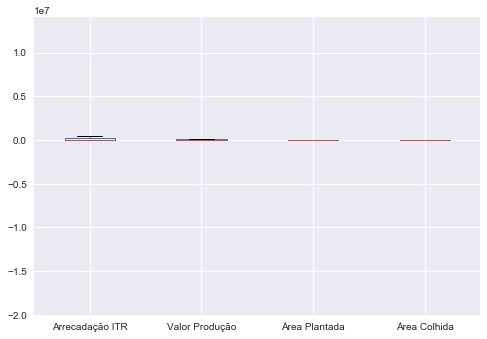

In [21]:
# Aplicando o boxplot para verificação da distribuição dos dados;
# Neste gráfico ficou demonstrado um outlier na coluna de arrecadação de ITR. Não é adequado termos nesta coluna um valor
# negativo expressivo, já que a arrecadação do município no mínimo deve ser zero.

boxplot = df_arr_itr.boxplot(column=['Arrecadação ITR', 'Valor Produção', 'Área Plantada', 'Área Colhida'])

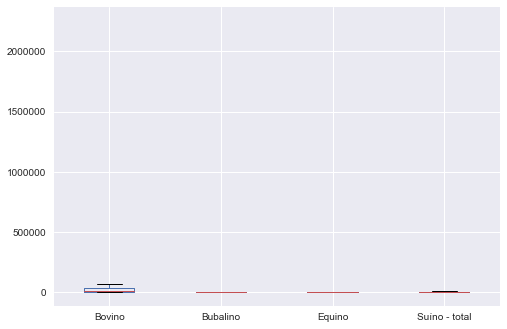

In [22]:
# Identifica-se pelo gráfico abaixo outlier muito positivos, o que é muito normal, já que ocorrem municípios muito produtivos
# em determinada atividade econômica pecuária ou agrícola.

boxplot = df_arr_itr.boxplot(column=['Bovino', 'Bubalino', 'Equino', 'Suíno - total'])

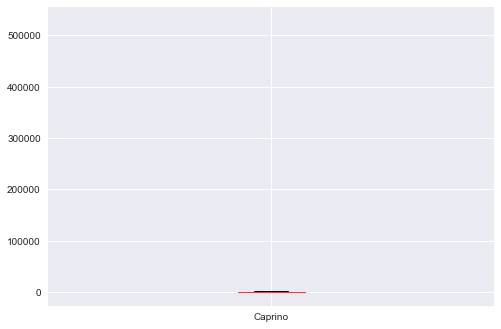

In [23]:
# Identifica-se pelo gráfico abaixo outlier muito positivos, o que é muito normal, já que ocorrem municípios muito produtivos
# em determinada atividade econômica pecuária ou agrícola.

boxplot = df_arr_itr.boxplot(column=['Caprino'])

In [24]:
# Ordenando a coluna de Arrecadação de ITR para identificar a linha do outlier que está muito destoado negativamente, conforme 
#demonstrado acima;

df_ordenado = df_arr_itr.sort_values(by='Arrecadação ITR')
df_ordenado.head(-10)

,ANO,Arrecadação ITR,Valor Produção,Área Plantada,Área Colhida,Município,Bovino,Bubalino,Equino,Suíno - total,Caprino,Ovino,Galináceos - total,Codornas,UF
13820,2018.0,-18540994.84,586.0,113.0,113.0,CURITIBA,1211.0,4.0,290.0,55.0,39.0,745.0,0.0,0.0,PR
17582,2019.0,0.00,1024.0,1116.0,1116.0,PAULINO NEVES,3384.0,41.0,709.0,6697.0,5176.0,7526.0,51602.0,0.0,MA
16571,2019.0,0.00,14303.0,2114.0,2114.0,EIRUNEPE,10882.0,64.0,222.0,3400.0,150.0,240.0,11000.0,0.0,AM
16570,2019.0,0.00,112954.0,5170.0,5132.0,CODAJAS,2408.0,1304.0,70.0,280.0,15.0,260.0,10100.0,0.0,AM
21294,2019.0,0.00,0.0,0.0,0.0,CUBATAO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SP
19026,2019.0,0.00,118.0,13.0,13.0,BAYEUX,300.0,0.0,84.0,1000.0,130.0,110.0,4100.0,0.0,PB
21265,2019.0,0.00,0.0,0.0,0.0,CARAPICUIBA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SP
19040,2019.0,0.00,0.0,0.0,0.0,CABEDELO,151.0,0.0,36.0,412.0,94.0,24.0,550.0,0.0,PB
21637,2019.0,0.00,0.0,0.0,0.0,SANTO ANDRE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SP
16562,2019.0,0.00,5751.0,902.0,882.0,NOVO AIRAO,326.0,6.0,64.0,150.0,10.0,50.0,20200.0,0.0,AM


In [25]:
df_arr_itr.dtypes

ANO                   float64
Arrecadação ITR       float64
Valor Produção        float64
Área Plantada         float64
Área Colhida          float64
Município              object
Bovino                float64
Bubalino              float64
Equino                float64
Suíno - total         float64
Caprino               float64
Ovino                 float64
Galináceos - total    float64
Codornas              float64
UF                     object
dtype: object

In [26]:
# Retirando a linha com o outlier. Este valor de Arrecadação do ITR é totalmente incompatível com o sentido do atributo. Não há
# como existir arrecadação negativa em algum município. Provavelmente, isso ocorreu por conta de erro na base de dados;

df_arr_itr = df_arr_itr.drop(13820)

In [27]:
# Histograma com principais atributos do dataset;

df_arr_itr.Arrecadação ITR.hist(bins = 50)

SyntaxError: invalid syntax (<ipython-input-27-2f0d2758e329>, line 4)

In [28]:
print(df_arr_itr.('Municipio')['Gravata'])

SyntaxError: invalid syntax (<ipython-input-28-685cb619c121>, line 1)

In [29]:
print(df_arr_itr.isnull().sum())


ANO                   0
Arrecadação ITR       0
Valor Produção        0
Área Plantada         0
Área Colhida          0
Município             0
Bovino                0
Bubalino              0
Equino                0
Suíno - total         0
Caprino               0
Ovino                 0
Galináceos - total    0
Codornas              0
UF                    0
dtype: int64


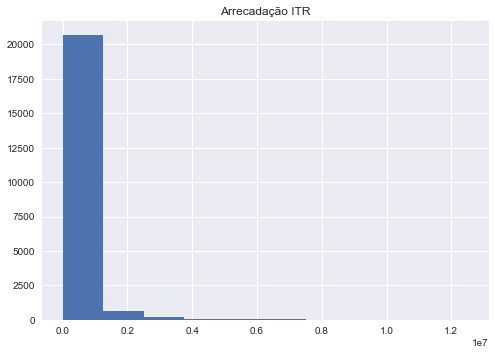

In [30]:
hist = df_arr_itr.hist('Arrecadação ITR')

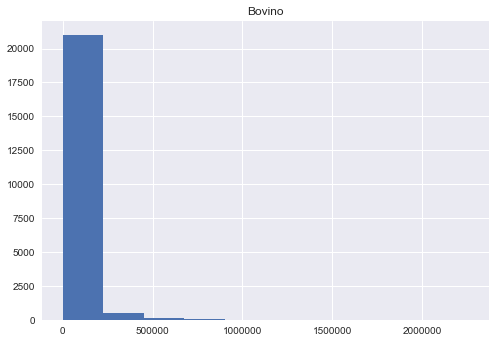

In [31]:
hist = df_arr_itr.hist('Bovino')

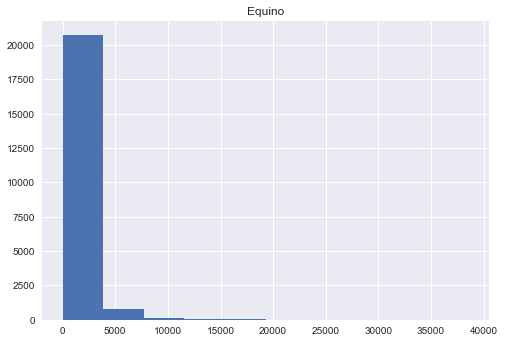

In [32]:
hist = df_arr_itr.hist('Equino')

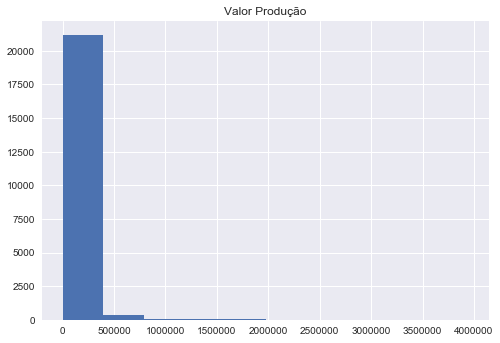

In [33]:
hist = df_arr_itr.hist('Valor Produção')


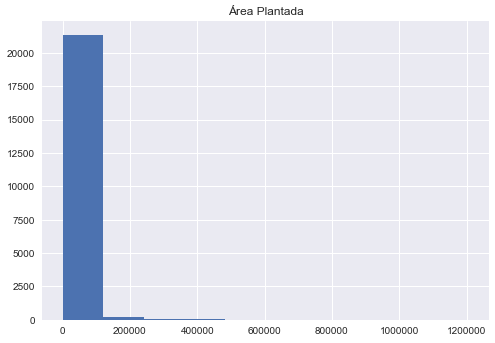

In [34]:
hist = df_arr_itr.hist('Área Plantada')

In [35]:
# A correlação tradicional (Pearson) supõe que as variáveis possuem distribuição normal, se não tiverem, melhor usar a 
# correlação de Spearman

df_arr_itr.corr(method='pearson')

,ANO,Arrecadação ITR,Valor Produção,Área Plantada,Área Colhida,Bovino,Bubalino,Equino,Suíno - total,Caprino,Ovino,Galináceos - total,Codornas
ANO,1.000000,0.047075,0.017743,0.004366,0.006178,-0.003466,0.001066,0.011301,0.000452,0.008326,0.006573,0.008528,0.004650
Arrecadação ITR,0.047075,1.000000,0.672665,0.666249,0.666868,0.517276,0.001311,0.476473,0.189072,-0.033321,0.107717,0.188331,-0.002766
Valor Produção,0.017743,0.672665,1.000000,0.940440,0.941030,0.178078,-0.006629,0.202469,0.262353,0.017848,0.074376,0.266795,0.005590
Área Plantada,0.004366,0.666249,0.940440,1.000000,0.999724,0.184116,-0.009127,0.185146,0.289456,-0.020220,0.054446,0.281295,-0.001852
Área Colhida,0.006178,0.666868,0.941030,0.999724,1.000000,0.184036,-0.009002,0.184074,0.289677,-0.023476,0.050211,0.281943,-0.001683
Bovino,-0.003466,0.517276,0.178078,0.184116,0.184036,1.000000,0.019197,0.789057,0.059997,-0.030292,0.101620,0.018387,-0.008023
Bubalino,0.001066,0.001311,-0.006629,-0.009127,-0.009002,0.019197,1.000000,0.094287,-0.000431,-0.006478,-0.001375,-0.011117,-0.003275
Equino,0.011301,0.476473,0.202469,0.185146,0.184074,0.789057,0.094287,1.000000,0.058472,0.040170,0.288441,0.038152,-0.006173
Suíno - total,0.000452,0.189072,0.262353,0.289456,0.289677,0.059997,-0.000431,0.058472,1.000000,0.002386,0.013511,0.437810,0.005116
Caprino,0.008326,-0.033321,0.017848,-0.020220,-0.023476,-0.030292,-0.006478,0.040170,0.002386,1.000000,0.789633,-0.026695,-0.006836


In [36]:

df_arr_itr.corr(method='spearman')

,ANO,Arrecadação ITR,Valor Produção,Área Plantada,Área Colhida,Bovino,Bubalino,Equino,Suíno - total,Caprino,Ovino,Galináceos - total,Codornas
ANO,1.000000,0.045805,0.000935,-0.019809,-0.009434,-0.012253,0.005453,0.008444,-0.012621,-0.003977,-0.000823,0.014356,0.015790
Arrecadação ITR,0.045805,1.000000,0.653566,0.565221,0.579153,0.540058,0.391167,0.467592,0.127018,-0.228515,0.065069,0.233117,0.068933
Valor Produção,0.000935,0.653566,1.000000,0.888908,0.906405,0.337148,0.262717,0.195410,0.260350,-0.183234,0.073380,0.360630,0.157084
Área Plantada,-0.019809,0.565221,0.888908,1.000000,0.989582,0.337758,0.163215,0.220236,0.358125,0.030066,0.285048,0.383909,0.127241
Área Colhida,-0.009434,0.579153,0.906405,0.989582,1.000000,0.338832,0.178512,0.209403,0.350132,-0.001477,0.251323,0.381067,0.126937
Bovino,-0.012253,0.540058,0.337148,0.337758,0.338832,1.000000,0.446530,0.770167,0.383945,0.081192,0.290478,0.257829,0.014283
Bubalino,0.005453,0.391167,0.262717,0.163215,0.178512,0.446530,1.000000,0.415703,0.139610,-0.064730,0.043273,0.106721,0.050164
Equino,0.008444,0.467592,0.195410,0.220236,0.209403,0.770167,0.415703,1.000000,0.302474,0.262820,0.419154,0.182341,-0.019157
Suíno - total,-0.012621,0.127018,0.260350,0.358125,0.350132,0.383945,0.139610,0.302474,1.000000,0.330840,0.402989,0.536218,0.234277
Caprino,-0.003977,-0.228515,-0.183234,0.030066,-0.001477,0.081192,-0.064730,0.262820,0.330840,1.000000,0.713964,0.142375,-0.013092


In [37]:
df_arr_itr.describe().round(2)

,ANO,Arrecadação ITR,Valor Produção,Área Plantada,Área Colhida,Bovino,Bubalino,Equino,Suíno - total,Caprino,Ovino,Galináceos - total,Codornas
count,21712.00,21712.00,21712.00,21712.00,21712.00,21712.00,21712.00,21712.00,21712.00,21712.00,21712.00,21712.00,21712.00
mean,2017.50,260541.51,60941.68,14403.64,14224.04,39036.04,251.28,1025.01,7437.69,1904.40,3380.23,258517.61,2939.02
std,1.12,712010.32,162405.71,44318.76,44165.04,91337.31,3234.67,1676.70,30717.49,11815.69,13294.85,875041.13,51351.84
min,2016.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2017.00,10364.55,2515.00,953.00,840.00,5711.25,0.00,209.00,593.00,37.00,187.00,9449.00,0.00
50%,2018.00,39179.49,14740.00,3519.00,3340.00,13229.50,0.00,503.00,1674.00,134.00,651.00,26104.00,0.00
75%,2019.00,182958.30,58058.75,11572.50,11418.75,32173.75,45.00,1155.00,4513.75,602.00,2100.00,115000.00,0.00
max,2019.00,12527912.89,3946318.00,1205669.00,1205669.00,2256734.00,175439.00,38546.00,1182705.00,528867.00,463670.00,19561445.00,3680464.00


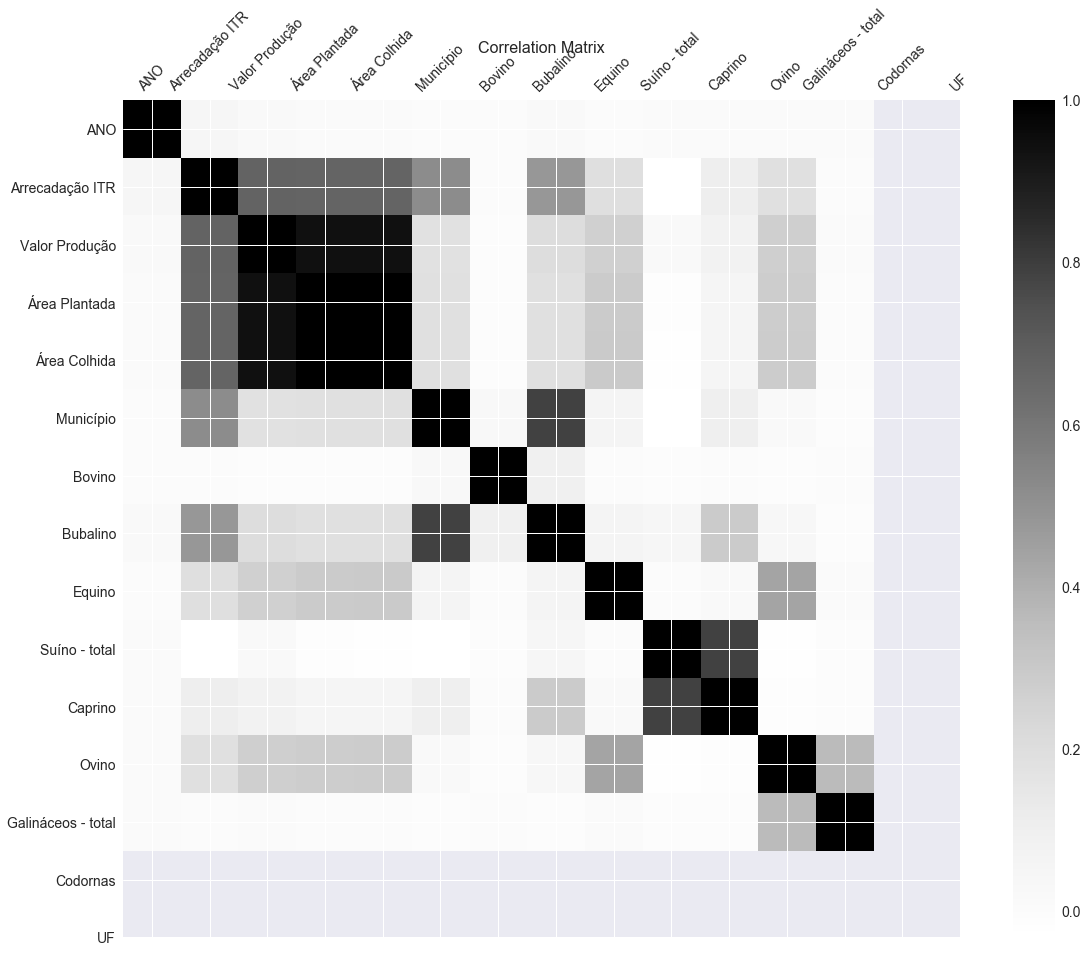

In [38]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df_arr_itr.corr(), fignum=f.number)
plt.xticks(range(df_arr_itr.shape[1]), df_arr_itr.columns, fontsize=14, rotation=45)
plt.yticks(range(df_arr_itr.shape[1]), df_arr_itr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

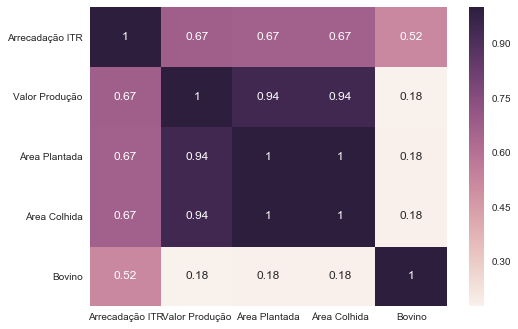

In [39]:
sns.set(style="darkgrid")
ax1 = sns.heatmap(df_arr_itr[["Arrecadação ITR", "Valor Produção", "Área Plantada", "Área Colhida", "Bovino"]].corr(), annot=True)

In [40]:
# Filtrando para formação do Data definitivo para rodar os modelos a serem escolhidos de Regressão


values=['SP']
filtered_df_arr_itr = df_arr_itr[df_arr_itr.UF.isin(values)]

filtered_df_arr_itr.head()

,ANO,Arrecadação ITR,Valor Produção,Área Plantada,Área Colhida,Município,Bovino,Bubalino,Equino,Suíno - total,Caprino,Ovino,Galináceos - total,Codornas,UF
4634,2016.0,59733.51,31043.0,7165.0,7165.0,BREJO ALEGRE,4279.0,0.0,75.0,0.0,0.0,28.0,0.0,0.0,SP
4635,2016.0,28609.58,7148.0,440.0,440.0,CANAS,4484.0,0.0,82.0,208.0,57.0,55.0,355.0,0.0,SP
4636,2016.0,35884.24,10227.0,1323.0,1323.0,FERNAO,7802.0,0.0,220.0,40.0,0.0,250.0,0.0,0.0,SP
4637,2016.0,494128.95,64882.0,9819.0,9819.0,GAVIAO PEIXOTO,1616.0,16.0,17.0,95.0,0.0,0.0,49636.0,0.0,SP
4638,2016.0,61589.86,26704.0,3565.0,3545.0,IPIGUA,7477.0,199.0,497.0,850.0,0.0,1530.0,221822.0,0.0,SP


In [41]:
values=['GRAVATA']
filtered_df_arr_itr_Gravata = df_arr_itr[df_arr_itr.Município.isin(values)]

filtered_df_arr_itr_Gravata.head()

,ANO,Arrecadação ITR,Valor Produção,Área Plantada,Área Colhida,Município,Bovino,Bubalino,Equino,Suíno - total,Caprino,Ovino,Galináceos - total,Codornas,UF
3208,2016.0,82750.36,6484.0,1470.0,1470.0,GRAVATA,16969.0,51.0,3173.0,3066.0,7000.0,7500.0,108500.0,12500.0,PE
8682,2017.0,106092.15,9828.0,550.0,550.0,GRAVATA,17067.0,52.0,3240.0,3057.0,6998.0,17041.0,90500.0,11000.0,PE
14155,2018.0,86145.06,8372.0,675.0,675.0,GRAVATA,15500.0,62.0,3548.0,3090.0,7447.0,16952.0,90000.0,10500.0,PE
19656,2019.0,110457.17,27967.0,1640.0,1640.0,GRAVATA,16370.0,40.0,3340.0,3190.0,7429.0,16504.0,75000.0,11000.0,PE


In [42]:
values=['UBERLANDIA']
filtered_df_arr_itr_Uberlandia = df_arr_itr[df_arr_itr.Município.isin(values)]

filtered_df_arr_itr_Uberlandia.head()

,ANO,Arrecadação ITR,Valor Produção,Área Plantada,Área Colhida,Município,Bovino,Bubalino,Equino,Suíno - total,Caprino,Ovino,Galináceos - total,Codornas,UF
2355,2016.0,4203621.26,452122.0,100582.0,99582.0,UBERLANDIA,229797.0,128.0,7030.0,656700.0,1950.0,3200.0,13340000.0,0.0,MG
7832,2017.0,4139810.59,440667.0,104672.0,104672.0,UBERLANDIA,224450.0,175.0,7117.0,638000.0,1995.0,2962.0,12950000.0,0.0,MG
13305,2018.0,5329499.31,516488.0,102617.0,102617.0,UBERLANDIA,216038.0,154.0,7235.0,619000.0,2004.0,3014.0,12858135.0,0.0,MG
18796,2019.0,6964112.24,564296.0,104043.0,104043.0,UBERLANDIA,210520.0,261.0,6545.0,624500.0,2125.0,2690.0,11986500.0,750.0,MG


In [43]:
values=['2019']
def_df_arr_itr = filtered_df_arr_itr[~filtered_df_arr_itr.ANO.isin(values)]

In [44]:
# Ajustando colunas string para aplicar os modelos de Regressão;

def_df_arr_itr = def_df_arr_itr.drop(['UF'], axis=1)
def_df_arr_itr = def_df_arr_itr.drop(['Município'], axis=1)

# Excluindo colunas com baixa correlação e com correlação iguais para ajuste;

def_df_arr_itr = def_df_arr_itr.drop(['Bubalino'], axis=1)
def_df_arr_itr = def_df_arr_itr.drop(['Codornas'], axis=1)
def_df_arr_itr = def_df_arr_itr.drop(['ANO'], axis=1)

In [45]:
print(def_df_arr_itr)

       Arrecadação ITR  Valor Produção  Área Plantada  Área Colhida   Bovino  \
4634          59733.51         31043.0         7165.0        7165.0   4279.0   
4635          28609.58          7148.0          440.0         440.0   4484.0   
4636          35884.24         10227.0         1323.0        1323.0   7802.0   
4637         494128.95         64882.0         9819.0        9819.0   1616.0   
4638          61589.86         26704.0         3565.0        3545.0   7477.0   
4639          24515.59          3609.0          610.0         610.0   6000.0   
4640         191551.66         77893.0        24724.0       24724.0  10567.0   
4641          72109.49         22937.0         5369.0        5369.0  19286.0   
4642         663799.15         57679.0        10917.0       10917.0  18587.0   
4643         148788.89         16435.0         2224.0        2224.0   9621.0   
4644          17345.71          4869.0          648.0         648.0   8059.0   
4645         239773.11         47718.0  

In [46]:
c = def_df_arr_itr.corr().abs()

c = c["Arrecadação ITR"].sort_values()
print(c)

Caprino               0.101316
Suíno - total         0.102934
Galináceos - total    0.103659
Bovino                0.254842
Equino                0.287340
Ovino                 0.324102
Valor Produção        0.697405
Área Plantada         0.730160
Área Colhida          0.730170
Arrecadação ITR       1.000000
Name: Arrecadação ITR, dtype: float64


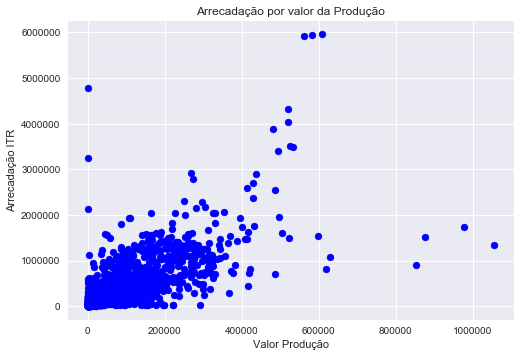

In [47]:
# Demonstração gráfica das maiores correlações;

from pylab import scatter, show, title, xlabel, ylabel, plot, contour
scatter(def_df_arr_itr['Valor Produção'], def_df_arr_itr['Arrecadação ITR'], marker='o', c='b')
title('Arrecadação por valor da Produção')
xlabel('Valor Produção')
ylabel('Arrecadação ITR')
show()

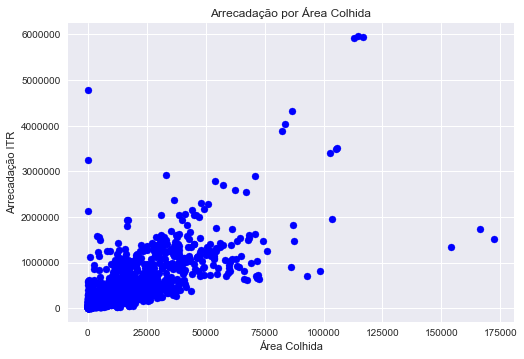

In [48]:
scatter(def_df_arr_itr['Área Colhida'], def_df_arr_itr['Arrecadação ITR'], marker='o', c='b')
title('Arrecadação por Área Colhida')
xlabel('Área Colhida')
ylabel('Arrecadação ITR')
show()

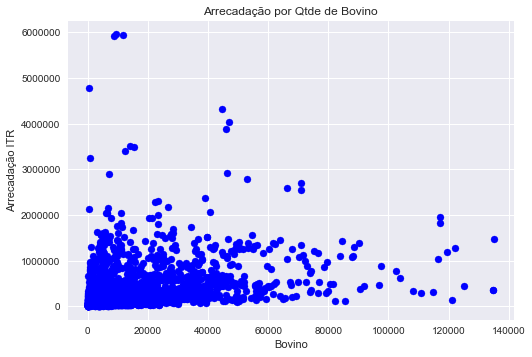

In [49]:
scatter(def_df_arr_itr['Bovino'], def_df_arr_itr['Arrecadação ITR'], marker='o', c='b')
title('Arrecadação por Qtde de Bovino')
xlabel('Bovino')
ylabel('Arrecadação ITR')
show()

In [52]:
#Gerando X e Y e dividindo em treinamento e validação

print(def_df_arr_itr.shape)

y = def_df_arr_itr['Arrecadação ITR']
x = def_df_arr_itr.drop(['Arrecadação ITR'], axis=1).values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=17)

(1880, 10)


In [53]:
# Verificando o erro quadrático como se toda a Arrecadação ITR fosse 0;
print(rmse(y_test, np.zeros(y_test.shape)))

722779.9277038209


In [54]:
er = LinearRegression()
er.fit(x_train, y_train)

print("R^2 na base de treinamento: {:.2f}".format(er.score(x_train, y_train)))
print("R^2 na base de teste: {:.2f}".format(er.score(x_test, y_test)))

print(rmse(y_test, er.predict(x_test)))

R^2 na base de treinamento: 0.56
R^2 na base de teste: 0.53
401349.0826963889


In [61]:
r2 = RandomForestRegressor(n_estimators= 300, random_state=17, max_depth=5, min_samples_leaf=2)

r2.fit(x_train, y_train)

print("R^2 na base de treinamento: {:.2f}".format(r2.score(x_train, y_train)))
print("R^2 na base de teste: {:.2f}".format(r2.score(x_test, y_test)))

r3 = xgb.XGBRegressor(objective='reg:squarederror', nrounds=100, max_depth=3, eta=0.05, min_child_weight=7, gamma=0.2,
                      colsample_bytree=0.4, learning_rate=0.15, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

r3.fit(x_train, y_train)

print("R^2 na base de treinamento: {:.2f}".format(r3.score(x_train, y_train)))
print("R^2 na base de teste: {:.2f}".format(r3.score(x_test, y_test)))


R^2 na base de treinamento: 0.78
R^2 na base de teste: 0.59
[21:30:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { cv, nrounds, scoring, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


R^2 na base de treinamento: 0.84
R^2 na base de teste: 0.70


In [87]:
kf =KFold(n_splits=5, random_state=None, shuffle=True)
for train_index, test_index in kf.split(x_train):
    x_train_k, x_test_k = x_train[train_index], x_train[test_index]
    y_train_k, y_test_k = y_train.to_numpy()[train_index], y_train.to_numpy()[test_index]

    er.fit(x_train_k, y_train_k)
    y_pred = er.predict(x_test_k)
    
    print("{:.2f}".format(rmse(y_test_k, y_pred)))
    
model  = LinearRegression()
result = cross_val_score(model, x, y, cv = kf)

print("K-Fold (R^2) Scores: {0}".format(result))
print("Mean R^2 for Cross-Validation K-Fold: {0}".format(result.mean()))   
   

AttributeError: 'Series' object has no attribute 'to_numpy'

In [62]:
ridge = Ridge().fit(x_train, y_train)
print("Ridge alpha=1")
print("R^2 na base de treinamento: {:.2f}".format(ridge.score(x_train, y_train)))
print("R^2 na base de teste: {:.2f}".format(ridge.score(x_test, y_test)))

Ridge alpha=1
R^2 na base de treinamento: 0.56
R^2 na base de teste: 0.53


In [63]:
lasso = Lasso().fit(x_train, y_train)
print("Lasso alpha=1")
print("R^2 na base de treinamento: {:.2f}".format(lasso.score(x_train, y_train)))
print("R^2 na base de teste: {:.2f}".format(lasso.score(x_test, y_test)))
print("Número de atributos usados: {}".format(np.sum(lasso.coef_ != 0)))



Lasso alpha=1
R^2 na base de treinamento: 0.56
R^2 na base de teste: 0.53
Número de atributos usados: 9


C:\Users\04138461485\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [90]:
# Verificando a predição de um município específico;

print(def_df_arr_itr.loc[16192])

Arrecadação ITR       120110.37
Valor Produção         39881.00
Área Plantada           5084.00
Área Colhida            5084.00
Bovino                 10640.00
Equino                   140.00
Suíno - total            168.00
Caprino                    0.00
Ovino                      0.00
Galináceos - total      2300.00
Name: 16192, dtype: float64


In [91]:
def_df_arr_itr.loc[16192]
x_16192 = def_df_arr_itr.loc[16192]
x_16192 = x_16192.drop(['Arrecadação ITR']).values
r3.predict(x_16192.reshape((1,-1)))

array([ 145037.625], dtype=float32)

In [77]:
print(df_arr_itr.loc[18796])

ANO                          2019
Arrecadação ITR       6.96411e+06
Valor Produção             564296
Área Plantada              104043
Área Colhida               104043
Município              UBERLANDIA
Bovino                     210520
Bubalino                      261
Equino                       6545
Suíno - total              624500
Caprino                      2125
Ovino                        2690
Galináceos - total    1.19865e+07
Codornas                      750
UF                             MG
Name: 18796, dtype: object


In [78]:
df_arr_itr_2019.loc[18796]
x_18796 = df_arr_itr_2019.loc[18796]
x_18796 = x_18796.drop(['Arrecadação ITR']).values
r3.predict(x_18796.reshape((1,-1)))

array([ 3017402.5], dtype=float32)

In [72]:
# Filtrando base para rodar o modelo de predição escolhido;

values=['2019']
df_arr_itr_2019 = df_arr_itr[df_arr_itr.ANO.isin(values)]
df_arr_itr_2019 = df_arr_itr_2019.drop(['UF'], axis=1)
df_arr_itr_2019 = df_arr_itr_2019.drop(['Município'], axis=1)
df_arr_itr_2019 = df_arr_itr_2019.drop(['Bubalino'], axis=1)
df_arr_itr_2019 = df_arr_itr_2019.drop(['Codornas'], axis=1)
df_arr_itr_2019 = df_arr_itr_2019.drop(['ANO'], axis=1)
df_arr_itr_2019.head()

,Arrecadação ITR,Valor Produção,Área Plantada,Área Colhida,Bovino,Equino,Suíno - total,Caprino,Ovino,Galináceos - total
16429,43853.18,14408.0,3413.0,3353.0,262722.0,5392.0,16178.0,693.0,5581.0,436731.0
16430,15144.12,26209.0,4757.0,4454.0,37997.0,1471.0,2991.0,1517.0,1409.0,250578.0
16431,5738.61,18273.0,3396.0,3303.0,17037.0,385.0,3133.0,280.0,250.0,71389.0
16432,26015.70,33008.0,7069.0,6846.0,132496.0,4365.0,28650.0,415.0,13128.0,146230.0
16433,240910.37,28256.0,6013.0,5908.0,474375.0,18909.0,10519.0,1798.0,12976.0,305339.0


In [74]:
print(df_arr_itr.loc[19656])

ANO                      2019
Arrecadação ITR        110457
Valor Produção          27967
Área Plantada            1640
Área Colhida             1640
Município             GRAVATA
Bovino                  16370
Bubalino                   40
Equino                   3340
Suíno - total            3190
Caprino                  7429
Ovino                   16504
Galináceos - total      75000
Codornas                11000
UF                         PE
Name: 19656, dtype: object


In [73]:
df_arr_itr_2019.loc[19656]
x_19656 = df_arr_itr_2019.loc[19656]
x_19656 = x_19656.drop(['Arrecadação ITR']).values
r3.predict(x_19656.reshape((1,-1)))

array([ 428376.625], dtype=float32)

In [79]:
arrec_original_2019 = df_arr_itr_2019['Arrecadação ITR']
b = df_arr_itr_2019.drop(['Arrecadação ITR'], axis=1).values

#b = df_arr_itr_2019[['Valor Produção','Área Plantada', 'Área Colhida', 'Bovino', 'Equino', 'Ovino']]
arrec_predict_2019 = r2.predict(b)
#print(c)
print(sum(arrec_original_2019))
print(sum(arrec_predict_2019))

1703512430.87
2126494936.52


# Diferença de Arrecadação de aproximadamente 423 milhões de reais;